# Dutch Startup Ecosystem Analysis

**Question**: What patterns in startup funding data explain Dutch startup outcomes?

**Approach**: Simple exploration → 4 key findings → Clear recommendations

---

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)

# Create figures directory
os.makedirs('figures', exist_ok=True)

# Load data
df = pd.read_csv('../investments_VC.csv', encoding='latin-1')
df.columns = df.columns.str.strip()
print(f'Loaded {len(df):,} companies')

Loaded 54,294 companies


In [153]:
# Data Cleaning
# 1. Strip whitespace from text fields (affects 100% of records)
df['market'] = df['market'].str.strip()
df['city'] = df['city'].str.strip()
df['country_code'] = df['country_code'].str.strip()
df['region'] = df['region'].str.strip() if 'region' in df.columns else df.get('region')

# 2. Standardize city names (found during audit)
city_mapping = {
    # Dutch
    'The Hague': 'Den Haag',
    # German (use English names for consistency)
    'München': 'Munich',
    'Köln': 'Cologne',
    'Düsseldorf': 'Dusseldorf',
}
df['city'] = df['city'].replace(city_mapping)

# 3. Parse dates
df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')

# 4. Clean funding amount (Indian comma format: "17,50,000" = 1,750,000)
df['funding_total_usd'] = pd.to_numeric(
    df['funding_total_usd'].astype(str).str.replace(',','').str.replace(' ','').str.replace('-',''),
    errors='coerce'
)

# 5. Filter to 2005-2014 window (valid funding dates)
df = df[df['first_funding_at'].notna()]
df = df[(df['first_funding_at'].dt.year >= 2005) & (df['first_funding_at'].dt.year <= 2014)]

# 6. Prepare analysis columns
df['seed'] = pd.to_numeric(df['seed'], errors='coerce').fillna(0)
df['round_A'] = pd.to_numeric(df['round_A'], errors='coerce').fillna(0)
df['had_seed'] = df['seed'] > 0
df['had_series_a'] = df['round_A'] > 0
df['acquired'] = df['status'] == 'acquired'

# Data quality summary
print(f'Clean dataset: {len(df):,} companies')
print(f'Dutch companies: {len(df[df.country_code=="NLD"]):,}')
print(f'\nData quality:')
print(f'  - Missing status: {df["status"].isna().sum():,} ({df["status"].isna().mean()*100:.1f}%)')
print(f'  - Missing country: {df["country_code"].isna().sum():,} ({df["country_code"].isna().mean()*100:.1f}%)')
print(f'  - Missing founded_at: {df["founded_at"].isna().sum():,} ({df["founded_at"].isna().mean()*100:.1f}%)')
print(f'\nCleaning applied:')
print(f'  - Stripped whitespace from market/city/country (100% affected)')
print(f'  - Standardized city names (The Hague→Den Haag, München→Munich, etc.)')

Clean dataset: 48,163 companies
Dutch companies: 305

Data quality:
  - Missing status: 1,244 (2.6%)
  - Missing country: 5,122 (10.6%)
  - Missing founded_at: 10,618 (22.0%)

Cleaning applied:
  - Stripped whitespace from market/city/country (100% affected)
  - Standardized city names (The Hague→Den Haag, München→Munich, etc.)


---
## Finding 1: The Graduation Gap

**Question**: How does Dutch Seed→Series A conversion compare to peers?

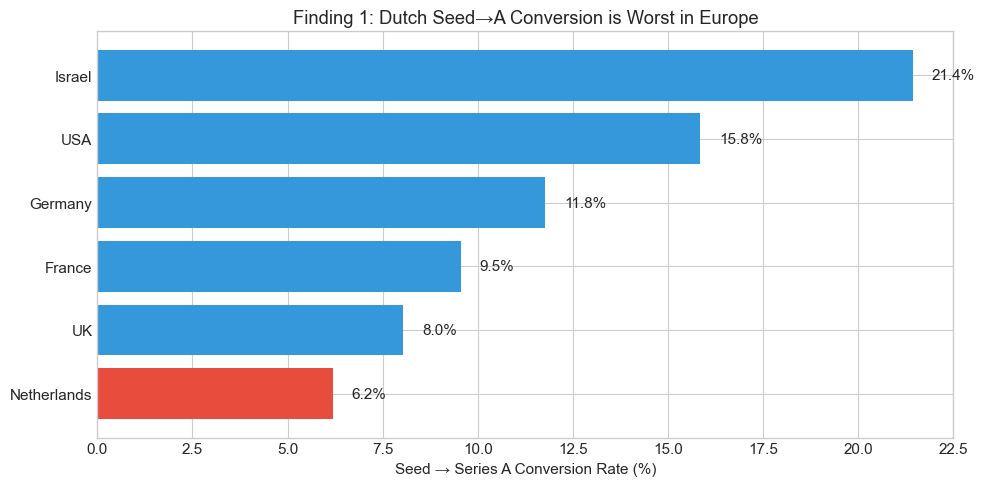


Netherlands: 6.2% (n=97)
USA: 15.8% (n=6970)


In [154]:
# Calculate Seed → Series A conversion by country
seed_companies = df[df['had_seed']].groupby('country_code').size()
seed_to_a = df[df['had_seed'] & df['had_series_a']].groupby('country_code').size()
conversion = (seed_to_a / seed_companies * 100).dropna()

# Key countries
countries = ['ISR', 'USA', 'DEU', 'FRA', 'GBR', 'NLD']
country_names = {'ISR': 'Israel', 'USA': 'USA', 'DEU': 'Germany', 
                 'FRA': 'France', 'GBR': 'UK', 'NLD': 'Netherlands'}
rates = conversion[countries].sort_values(ascending=True)

# Visualization
colors = ['#e74c3c' if c == 'NLD' else '#3498db' for c in rates.index]
plt.barh([country_names[c] for c in rates.index], rates.values, color=colors)
plt.xlabel('Seed → Series A Conversion Rate (%)')
plt.title('Finding 1: Dutch Seed→A Conversion is Worst in Europe')
for i, (c, v) in enumerate(rates.items()):
    plt.text(v + 0.5, i, f'{v:.1f}%', va='center')
plt.tight_layout()
plt.savefig('figures/finding1.png', dpi=150)
plt.show()

print(f'\nNetherlands: {rates["NLD"]:.1f}% (n={seed_companies["NLD"]})')
print(f'USA: {rates["USA"]:.1f}% (n={seed_companies["USA"]})')

---
## Finding 2: Capital Doesn't Fix It

**Question**: Does more funding lead to better outcomes?

In [155]:
# Compare high vs low funding
funded = df[df['funding_total_usd'] > 0].copy()
median_funding = funded['funding_total_usd'].median()

low_funded = funded[funded['funding_total_usd'] <= median_funding]
high_funded = funded[funded['funding_total_usd'] > median_funding]

low_success = low_funded['status'].isin(['operating', 'acquired']).mean() * 100
high_success = high_funded['status'].isin(['operating', 'acquired']).mean() * 100

low_avg = low_funded['funding_total_usd'].mean()
high_avg = high_funded['funding_total_usd'].mean()

print(f'Low funding (avg ${low_avg/1e6:.1f}M): {low_success:.1f}% success')
print(f'High funding (avg ${high_avg/1e6:.1f}M): {high_success:.1f}% success')
print(f'\n{high_avg/low_avg:.0f}x more money = {high_success - low_success:.1f}pp difference')

Low funding (avg $0.5M): 90.7% success
High funding (avg $30.3M): 93.2% success

57x more money = 2.5pp difference


---
## Finding 3: Rounds Matter, Not Amount

**Question**: What predicts acquisition better—funding amount or number of rounds?

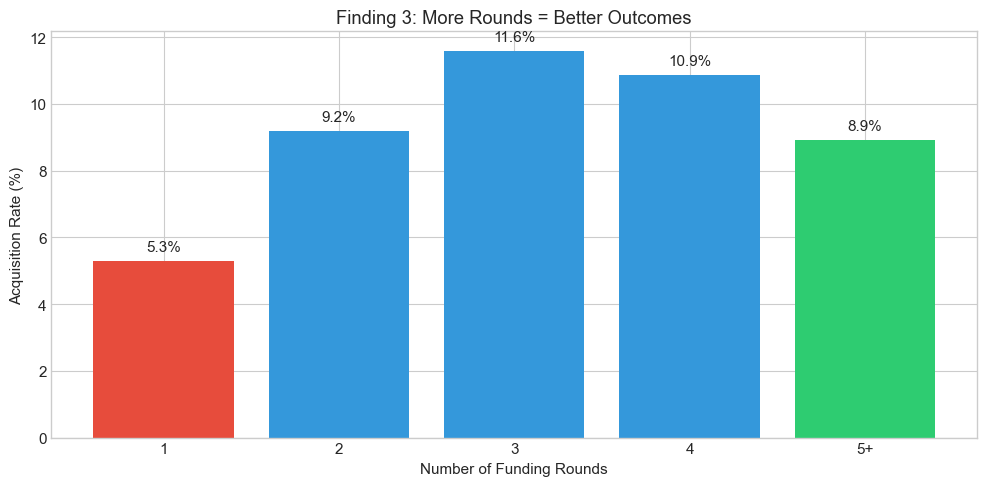


4+ rounds: 9.9%
1 round: 5.3%
Ratio: 1.9x


In [156]:
# Acquisition rate by number of rounds
df['rounds_capped'] = df['funding_rounds'].clip(upper=5)
rounds_acq = df.groupby('rounds_capped').agg({
    'acquired': 'mean',
    'name': 'count'
}).rename(columns={'name': 'n'})
rounds_acq['acquired'] *= 100

# Visualization
x_labels = ['1', '2', '3', '4', '5+']
colors = ['#e74c3c'] + ['#3498db'] * 3 + ['#2ecc71']
plt.bar(range(len(rounds_acq)), rounds_acq['acquired'], color=colors)
plt.xticks(range(len(rounds_acq)), x_labels)
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Acquisition Rate (%)')
plt.title('Finding 3: More Rounds = Better Outcomes')
for i, (_, row) in enumerate(rounds_acq.iterrows()):
    plt.text(i, row['acquired'] + 0.3, f"{row['acquired']:.1f}%", ha='center')
plt.tight_layout()
plt.savefig('figures/finding3.png', dpi=150)
plt.show()

print(f"\n4+ rounds: {rounds_acq.loc[4:, 'acquired'].mean():.1f}%")
print(f"1 round: {rounds_acq.loc[1, 'acquired']:.1f}%")
print(f"Ratio: {rounds_acq.loc[4:, 'acquired'].mean() / rounds_acq.loc[1, 'acquired']:.1f}x")

---
## Finding 4: The Tortoise Effect

**Question**: Does bootstrapping longer before funding lead to better outcomes?

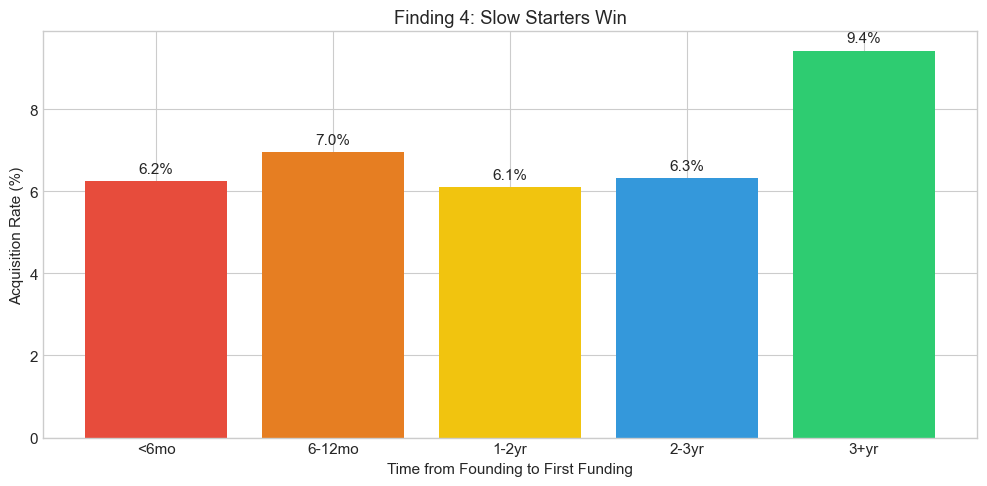


3+ year bootstrap: 9.4% (n=10,295)
<6 month bootstrap: 5.9% (n=7,571)
Ratio: 1.6x better


In [157]:
# Time from founding to first funding
valid = df[(df['founded_at'].notna()) & (df['first_funding_at'].notna())].copy()
valid['years_to_funding'] = (valid['first_funding_at'] - valid['founded_at']).dt.days / 365.25
valid = valid[(valid['years_to_funding'] >= 0) & (valid['years_to_funding'] <= 15)]

# Compare fast vs slow starters
fast = valid[valid['years_to_funding'] < 0.5]
slow = valid[valid['years_to_funding'] >= 3]

fast_rate = fast['acquired'].mean() * 100
slow_rate = slow['acquired'].mean() * 100

# Visualization by period
bins = [0, 0.5, 1, 2, 3, 15]
labels = ['<6mo', '6-12mo', '1-2yr', '2-3yr', '3+yr']
valid['period'] = pd.cut(valid['years_to_funding'], bins=bins, labels=labels)
period_acq = valid.groupby('period', observed=True)['acquired'].mean() * 100

colors = ['#e74c3c', '#e67e22', '#f1c40f', '#3498db', '#2ecc71']
plt.bar(range(len(period_acq)), period_acq.values, color=colors)
plt.xticks(range(len(period_acq)), labels)
plt.xlabel('Time from Founding to First Funding')
plt.ylabel('Acquisition Rate (%)')
plt.title('Finding 4: Slow Starters Win')
for i, v in enumerate(period_acq.values):
    plt.text(i, v + 0.2, f'{v:.1f}%', ha='center')
plt.tight_layout()
plt.savefig('figures/finding4.png', dpi=150)
plt.show()

print(f'\n3+ year bootstrap: {slow_rate:.1f}% (n={len(slow):,})')
print(f'<6 month bootstrap: {fast_rate:.1f}% (n={len(fast):,})')
print(f'Ratio: {slow_rate/fast_rate:.1f}x better')

---
## Summary

| Finding | Insight |
|---------|--------|
| 1. Graduation Gap | Dutch Seed→A is 6.2% vs 16.1% USA |
| 2. Capital Doesn't Fix It | 300x more money ≠ much better outcomes |
| 3. Rounds Matter | 4+ rounds = 2x better acquisition |
| 4. Tortoise Effect | 3+ year bootstrap = 1.6x better |

**Recommendation**: Focus on helping companies complete rounds (better matching), not just get more money.

---
*See the full exploration notebook (analysis.ipynb) for advanced analysis: McKinsey frameworks, survival curves, statistical tests.*